In [554]:
import warnings
warnings.simplefilter("ignore")

In [555]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [556]:
from sklearn.preprocessing import StandardScaler

In [557]:
from sklearn.decomposition import PCA

In [558]:
from sklearn.cluster import KMeans

# 1. Load data

olist_customers_dataset

In [559]:
df_customer = pd.read_csv('./dataset/olist_customers_dataset.csv')

In [560]:
df_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [561]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


olist_geolocation_dataset

In [562]:
df_geo = pd.read_csv('./dataset/olist_geolocation_dataset.csv')

In [563]:
df_geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [564]:
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


olist_order_items_dataset

In [565]:
df_order_item = pd.read_csv('./dataset/olist_order_items_dataset.csv')

In [566]:
df_order_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [567]:
df_order_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [568]:
df_order_item['shipping_limit_date'] = pd.to_datetime(df_order_item['shipping_limit_date'])

olist_order_payments_dataset

In [569]:
df_order_payment = pd.read_csv('./dataset/olist_order_payments_dataset.csv')

In [570]:
df_order_payment.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [571]:
df_order_payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


olist_order_reviews_dataset

In [572]:
df_order_review = pd.read_csv('./dataset/olist_order_reviews_dataset.csv')

In [573]:
df_order_review.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [574]:
df_order_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [575]:
df_order_review['review_creation_date'] = pd.to_datetime(df_order_review['review_creation_date'])
df_order_review['review_answer_timestamp'] = pd.to_datetime(df_order_review['review_answer_timestamp'])

olist_orders_dataset

In [576]:
df_order = pd.read_csv('./dataset/olist_orders_dataset.csv')

In [577]:
df_order.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [578]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [579]:
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'])
df_order['order_approved_at'] = pd.to_datetime(df_order['order_approved_at'])
df_order['order_delivered_carrier_date'] = pd.to_datetime(df_order['order_delivered_carrier_date'])
df_order['order_delivered_customer_date'] = pd.to_datetime(df_order['order_delivered_customer_date'])
df_order['order_estimated_delivery_date'] = pd.to_datetime(df_order['order_estimated_delivery_date'])

olist_products_dataset

In [580]:
df_product = pd.read_csv('./dataset/olist_products_dataset.csv')

In [581]:
df_product.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [582]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


olist_sellers_dataset

In [583]:
df_seller = pd.read_csv('./dataset/olist_sellers_dataset.csv')

In [584]:
df_seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [585]:
df_seller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


product_category_name_translation

In [586]:
df_cat_name = pd.read_csv('./dataset/product_category_name_translation.csv')

In [587]:
df_cat_name.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [588]:
df_cat_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


olist_age

In [589]:
df_age = pd.read_csv('./dataset/olist_age.csv')

In [590]:
df_age.head()

,customer_id,age
0,00012a2ce6f8dcda20d059ce98491703,61
1,000161a058600d5901f007fab4c27140,49
2,0001fd6190edaaf884bcaf3d49edf079,71
3,0002414f95344307404f0ace7a26f1d5,68
4,000379cdec625522490c315e70c7a9fb,61


In [591]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98666 entries, 0 to 98665
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  98666 non-null  object
 1   age          98666 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


# 2. Feature engineering

1. customer_id

In [592]:
df_customer_unique_id = duckdb.query("""
select distinct customer_unique_id
from df_customer
""").to_df()

In [593]:
df_customer_unique_id.head()

,customer_unique_id
0,259dac757896d24d7702b9acbbff3f3c
1,4390ddbb6276a66ff1736a6710205dca
2,424aca6872c5bab80780a8dec03b7516
3,3d49f4455a3947c8dd7e972b3ad8cb76
4,7677c213007e9a6ec9267ea50b5ce5bc


2. age

In [594]:
df_customer_age = duckdb.query("""
select b.customer_unique_id
, min(a.age) age
from df_age a
left join df_customer b
on a.customer_id = b.customer_id
group by b.customer_unique_id
""").to_df()

In [595]:
df_customer_age.head()

,customer_unique_id,age
0,e3cf594a99e810f58af53ed4820f25e5,38
1,15090f48004f3b0fc18a167ef82af4db,51
2,61f5df1a634167ff48d76d79d21226de,20
3,e36a621e869b643b15983fa8085eb541,36
4,934c19eeef04da89928f995df85cf3f8,21


3. customer address

In [596]:
df_customer_address = duckdb.query("""
select customer_unique_id
, case when customer_state in ('AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO') then 1 else 0 end address_north
, case when customer_state in ('AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE') then 1 else 0 end address_northeast
, case when customer_state in ('DF', 'GO', 'MT', 'MS') then 1 else 0 end address_centralwest
, case when customer_state in ('ES', 'MG', 'RJ', 'SP') then 1 else 0 end address_southeast
, case when customer_state in ('PR', 'RS', 'SC') then 1 else 0 end address_south
from
    (
    select customer_unique_id, customer_state, customer_city, customer_zip_code_prefix
    , row_number() over(partition by customer_unique_id order by customer_zip_code_prefix) rn
    from df_customer
    ) a
where rn = 1
""").to_df()

In [597]:
df_customer_address.head()

,customer_unique_id,address_north,address_northeast,address_centralwest,address_southeast,address_south
0,000ed48ceeb6f4bf8ad021a10a3c7b43,0,0,0,1,0
1,001deb796b28a3a128d6113857569aa4,0,0,0,1,0
2,00256bf7b05c08f6a5849df3d0a64f1f,0,0,0,1,0
3,002eb8b96288f3804e21d2777ac29895,0,0,0,1,0
4,0033f4a2887e07e25aa1204d482f41ba,0,1,0,0,0


4. recency

In [598]:
duckdb.query("""
select max(a.order_purchase_timestamp)
from df_order a
left join df_customer b on a.customer_id = b.customer_id
where a.order_status not in ('unavailable','canceled')
and a.order_purchase_timestamp is not null
""").to_df()

,max(a.order_purchase_timestamp)
0,2018-09-03 09:06:57


In [599]:
df_customer_recency = duckdb.query("""
select b.customer_unique_id
, max(cast(order_purchase_timestamp as datetime)) lastest_txn
, min(cast(order_purchase_timestamp as datetime)) first_txn
, min(datediff('day', cast(order_purchase_timestamp as datetime), cast('2018-09-04' as datetime))) as day_after_last_pur
from df_order a
left join df_customer b on a.customer_id = b.customer_id
where a.order_status not in ('unavailable','canceled')
group by b.customer_unique_id
""").to_df()

In [600]:
df_customer_recency.head()

,customer_unique_id,lastest_txn,first_txn,day_after_last_pur
0,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,2018-07-29 09:51:30,37
1,9afe194fb833f79e300e37e580171f22,2018-01-08 11:22:34,2018-01-08 11:22:34,239
2,7f3a72e8f988c6e735ba118d54f47458,2017-05-11 13:48:47,2017-05-11 13:48:47,481
3,07d190f123147d9e89d4b922543d7948,2018-07-08 09:59:19,2018-07-08 09:59:19,58
4,c9158d089637ab443c78984d20da7fc0,2018-01-31 16:43:25,2018-01-31 16:43:23,216


5. frequency

In [601]:
df_customer_frequency = duckdb.query("""
select b.customer_unique_id
, count(distinct order_id) no_order
from df_order a
left join df_customer b
on a.customer_id = b.customer_id
where a.order_status not in ('unavailable','canceled')
group by b.customer_unique_id
""").to_df()

In [602]:
df_customer_frequency.head()

,customer_unique_id,no_order
0,cd076285a12f40041b32f5ad8c98699f,1
1,755bdc2822a8f01cfcec19ae4dcaae66,1
2,a05262e3e3de722e0a42cfa3b48e622c,1
3,8377420a8b3549f6f40dca93815ee602,1
4,9316f45a5da8403a5938bd6069b1a4a7,1


6. monetary

In [603]:
df_customer_monetary = duckdb.query("""
select b.customer_unique_id
, sum(c.payment_value) total_amount
from df_order a
left join df_customer b
on a.customer_id = b.customer_id
left join df_order_payment c
on a.order_id = c.order_id
where a.order_status not in ('unavailable','canceled')
group by b.customer_unique_id
""").to_df()

In [604]:
df_customer_monetary.head()

,customer_unique_id,total_amount
0,57b2a98a409812fe9618067b6b8ebe4f,36.01
1,21f748a16f4e1688a9014eb3ee6fa325,169.23
2,a96d5cfa0d3181817e2b946f921ea021,232.71
3,e9dd12dca17352644a959d9dea133935,113.83
4,e079b18794454de9d2be5c12b4392294,437.78


7. prefered category

In [605]:
df_customer_preferred_cat = duckdb.query("""
select customer_unique_id
, count(distinct case when cat_new = 'home and kitchen' then product_id else null end)
/count(distinct product_id)*1.0 cat_home
, count(distinct case when cat_new = 'fashion and accessories' then product_id else null end)
/count(distinct product_id)*1.0 cat_fashion
, count(distinct case when cat_new = 'electronics and gadgets' then product_id else null end)
/count(distinct product_id)*1.0 cat_elec
, count(distinct case when cat_new = 'tools and construction' then product_id else null end)
/count(distinct product_id)*1.0 cat_tools
, count(distinct case when cat_new = 'health, beauty, and hygiene' then product_id else null end)
/count(distinct product_id)*1.0 cat_health_beauty
, count(distinct case when cat_new = 'books, music, and entertainment' then product_id else null end)
/count(distinct product_id)*1.0 cat_book_and_music
, count(distinct case when cat_new = 'toys and leisure' then product_id else null end)
/count(distinct product_id)*1.0 cat_toy
, count(distinct case when cat_new = 'miscellaneous' then product_id else null end)
/count(distinct product_id)*1.0 cat_others
from
    (
    select *
    , case when e.product_category_name_english in ('housewares', 'kitchen_dining_laundry_garden_furniture', 'home_confort', 'home_construction', 'home_appliances', 'home_appliances_2', 'bed_bath_table', 'furniture_bedroom', 'furniture_living_room', 'furniture_decor', 'furniture_mattress_and_upholstery', 'small_appliances', 'small_appliances_home_oven_and_coffee', 'garden_tools', 'home_comfort_2') then 'home and kitchen'
    when e.product_category_name_english in ('fashion_bags_accessories', 'fashion_male_clothing', 'fashion_sport', 'fashion_underwear_beach', 'fashion_childrens_clothes', 'fashion_shoes', 'fashio_female_clothing') then 'fashion and accessories'
    when e.product_category_name_english in ('electronics', 'fixed_telephony', 'consoles_games', 'audio', 'tablets_printing_image', 'computers_accessories', 'telephony', 'computers') then 'electronics and gadgets'
    when e.product_category_name_english in ('costruction_tools_garden', 'costruction_tools_tools', 'construction_tools_safety', 'construction_tools_lights', 'construction_tools_construction') then 'tools and construction'
    when e.product_category_name_english in ('health_beauty', 'diapers_and_hygiene') then 'health, beauty, and hygiene'
    when e.product_category_name_english in ('books_general_interest', 'books_imported', 'books_technical', 'music', 'cds_dvds_musicals', 'dvds_blu_ray', 'cine_photo') then 'books, music, and entertainment'
    when e.product_category_name_english in ('baby', 'sports_leisure', 'toys') then 'toys and leisure'
    else 'miscellaneous' end cat_new
    from df_order a
    left join df_customer b
    on a.customer_id = b.customer_id
    left join df_order_item c
    on a.order_id = c.order_id
    left join df_product d
    on c.product_id = d.product_id
    left join df_cat_name e
    on d.product_category_name = e.product_category_name
    where a.order_status not in ('unavailable','canceled')
    ) a
group by customer_unique_id
""").to_df()

In [606]:
df_customer_preferred_cat.head()

,customer_unique_id,cat_home,cat_fashion,cat_elec,cat_tools,cat_health_beauty,cat_book_and_music,cat_toy,cat_others
0,5ece49e012285b9003d084a4ea8a9c94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,ba66b6edd0756a62cb11be4d4655ed32,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1145616de76e14f4e7fd5452c2be149c,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,78c5f76b60a3a2588635aadc70e34df7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,af4d3cd0b29b208c971ff6ad78b41b79,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


8. prefered payment channel

In [607]:
df_customer_preferred_payment = duckdb.query("""
select b.customer_unique_id
, count(distinct case when payment_type = 'credit_card' then a.order_id else null end)
/count(distinct a.order_id)*1.0 payment_credit
, count(distinct case when payment_type = 'debit_card' then a.order_id else null end) 
/count(distinct a.order_id)*1.0 payment_debit
, count(distinct case when payment_type = 'boleto' then a.order_id else null end)
/count(distinct a.order_id)*1.0 payment_ticket
, count(distinct case when payment_type = 'voucher' then a.order_id else null end)
/count(distinct a.order_id)*1.0 payment_voucher
from df_order a
left join df_customer b
on a.customer_id = b.customer_id
left join df_order_payment c
on a.order_id = c.order_id
where a.order_status not in ('unavailable','canceled')
group by b.customer_unique_id
""").to_df()

In [608]:
df_customer_preferred_payment.head()

,customer_unique_id,payment_credit,payment_debit,payment_ticket,payment_voucher
0,809353196a0456095716566dd226bb48,1.0,0.0,0.0,0.0
1,1a7a10e9273fca58179bdd0d40843b0c,1.0,0.0,0.0,0.0
2,3574bc798156f406b12f377bf3fdd381,0.0,0.0,1.0,0.0
3,b7cb5cfc7e208d22aa17ef640f487d7a,1.0,0.0,0.0,0.0
4,9f16fd7755d607cff890d9af2f212340,1.0,0.0,0.0,0.0


9. review score

In [609]:
df_customer_review_score = duckdb.query("""
select b.customer_unique_id
, sum(c.review_score) avg_review_score
from df_order a
left join df_customer b
on a.customer_id = b.customer_id
left join df_order_review c
on a.order_id = c.order_id
where a.order_status not in ('unavailable','canceled')
group by b.customer_unique_id
""").to_df()

In [610]:
df_customer_review_score.head()

,customer_unique_id,avg_review_score
0,259dac757896d24d7702b9acbbff3f3c,5.0
1,424aca6872c5bab80780a8dec03b7516,4.0
2,3d49f4455a3947c8dd7e972b3ad8cb76,3.0
3,7677c213007e9a6ec9267ea50b5ce5bc,5.0
4,e5dbefdfdf3eff75c8e6cd655f128279,1.0


# 3. Join data

In [611]:
df = duckdb.query("""
select a.customer_unique_id
, b.age
, c.address_north, c.address_northeast, c.address_centralwest, c.address_southeast, c.address_south
, d.day_after_last_pur
, e.no_order
, f.total_amount
, g.cat_home, g.cat_fashion, g.cat_elec, g.cat_tools, g.cat_health_beauty
, g.cat_book_and_music, g.cat_toy, g.cat_others
, h.payment_credit, h.payment_debit, h.payment_ticket, h.payment_voucher
, i.avg_review_score

from df_customer_unique_id a
left join df_customer_age b
on a.customer_unique_id = b.customer_unique_id
left join df_customer_address c
on a.customer_unique_id = c.customer_unique_id
left join df_customer_recency d
on a.customer_unique_id = d.customer_unique_id
left join df_customer_frequency e
on a.customer_unique_id = e.customer_unique_id
left join df_customer_monetary f
on a.customer_unique_id = f.customer_unique_id
left join df_customer_preferred_cat g
on a.customer_unique_id = g.customer_unique_id
left join df_customer_preferred_payment h
on a.customer_unique_id = h.customer_unique_id
left join df_customer_review_score i
on a.customer_unique_id = i.customer_unique_id
""").to_df()

In [612]:
df.head()

,customer_unique_id,age,address_north,address_northeast,address_centralwest,address_southeast,address_south,day_after_last_pur,no_order,total_amount,...,cat_tools,cat_health_beauty,cat_book_and_music,cat_toy,cat_others,payment_credit,payment_debit,payment_ticket,payment_voucher,avg_review_score
0,259dac757896d24d7702b9acbbff3f3c,63.0,0,0,0,1,0,175.0,1.0,173.30,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0
1,4390ddbb6276a66ff1736a6710205dca,49.0,0,0,0,0,1,508.0,1.0,94.63,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0
2,424aca6872c5bab80780a8dec03b7516,64.0,0,0,0,1,0,357.0,1.0,73.34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
3,3d49f4455a3947c8dd7e972b3ad8cb76,71.0,0,0,0,1,0,218.0,1.0,157.12,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
4,7677c213007e9a6ec9267ea50b5ce5bc,30.0,0,0,0,1,0,196.0,1.0,18.77,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0


# 4. Handle missing value

In [613]:
df.isna().sum()

customer_unique_id        0
age                     676
address_north             0
address_northeast         0
address_centralwest       0
address_southeast         0
address_south             0
day_after_last_pur     1106
no_order               1106
total_amount           1107
cat_home               1113
cat_fashion            1113
cat_elec               1113
cat_tools              1113
cat_health_beauty      1113
cat_book_and_music     1113
cat_toy                1113
cat_others             1113
payment_credit         1106
payment_debit          1106
payment_ticket         1106
payment_voucher        1106
avg_review_score       1791
dtype: int64

In [614]:
df['day_after_last_pur'].fillna(0, inplace=True)
df['no_order'].fillna(0, inplace=True)
df['total_amount'].fillna(0, inplace=True)
df['cat_home'].fillna(0, inplace=True)
df['cat_fashion'].fillna(0, inplace=True)
df['cat_elec'].fillna(0, inplace=True)
df['cat_tools'].fillna(0, inplace=True)
df['cat_health_beauty'].fillna(0, inplace=True)
df['cat_book_and_music'].fillna(0, inplace=True)
df['cat_toy'].fillna(0, inplace=True)
df['cat_others'].fillna(0, inplace=True)
df['payment_credit'].fillna(0, inplace=True)
df['payment_debit'].fillna(0, inplace=True)
df['payment_ticket'].fillna(0, inplace=True)
df['payment_voucher'].fillna(0, inplace=True)

In [615]:
df['avg_review_score'].fillna(4.278182, inplace=True)

In [616]:
df['day_after_last_pur'].fillna(1000, inplace=True)

In [617]:
df.dropna(inplace=True)

In [618]:
df.head()

,customer_unique_id,age,address_north,address_northeast,address_centralwest,address_southeast,address_south,day_after_last_pur,no_order,total_amount,...,cat_tools,cat_health_beauty,cat_book_and_music,cat_toy,cat_others,payment_credit,payment_debit,payment_ticket,payment_voucher,avg_review_score
0,259dac757896d24d7702b9acbbff3f3c,63.0,0,0,0,1,0,175.0,1.0,173.30,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0
1,4390ddbb6276a66ff1736a6710205dca,49.0,0,0,0,0,1,508.0,1.0,94.63,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0
2,424aca6872c5bab80780a8dec03b7516,64.0,0,0,0,1,0,357.0,1.0,73.34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
3,3d49f4455a3947c8dd7e972b3ad8cb76,71.0,0,0,0,1,0,218.0,1.0,157.12,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
4,7677c213007e9a6ec9267ea50b5ce5bc,30.0,0,0,0,1,0,196.0,1.0,18.77,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0


# 5. Exploratory data analysis (EDA)

list of columns by types

In [619]:
df.columns.tolist()

['customer_unique_id',
 'age',
 'address_north',
 'address_northeast',
 'address_centralwest',
 'address_southeast',
 'address_south',
 'day_after_last_pur',
 'no_order',
 'total_amount',
 'cat_home',
 'cat_fashion',
 'cat_elec',
 'cat_tools',
 'cat_health_beauty',
 'cat_book_and_music',
 'cat_toy',
 'cat_others',
 'payment_credit',
 'payment_debit',
 'payment_ticket',
 'payment_voucher',
 'avg_review_score']

In [620]:
id_col = ['customer_unique_id']

In [621]:
cat_col = ['address_north','address_northeast','address_centralwest','address_southeast','address_south']

In [622]:
num_col = ['age',
           'day_after_last_pur','no_order','total_amount',
           'cat_home','cat_fashion','cat_elec','cat_tools','cat_health_beauty',
           'cat_book_and_music','cat_toy','cat_others',
           'payment_credit','payment_debit','payment_ticket','payment_voucher',
           'avg_review_score']

categorical features

In [623]:
df[cat_col].describe()

,address_north,address_northeast,address_centralwest,address_southeast,address_south
count,95420.000000,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.018665,0.095148,0.058248,0.685496,0.142444
std,0.135339,0.293420,0.234213,0.464321,0.349507
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


numeric feature

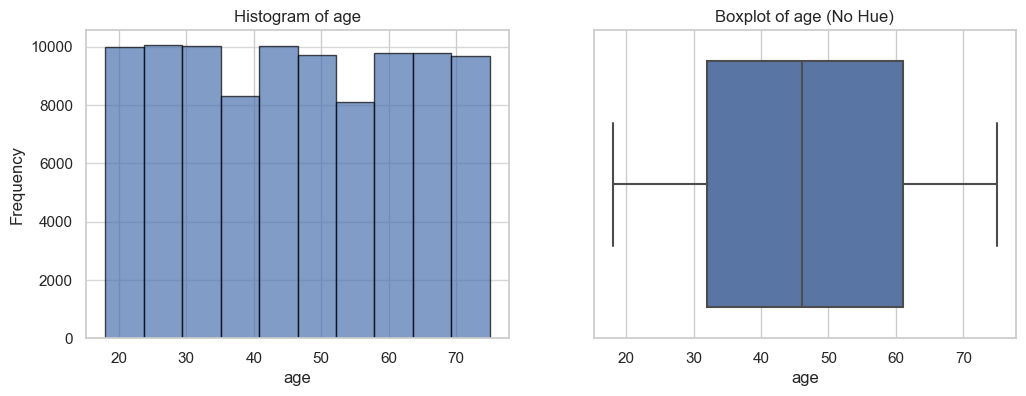

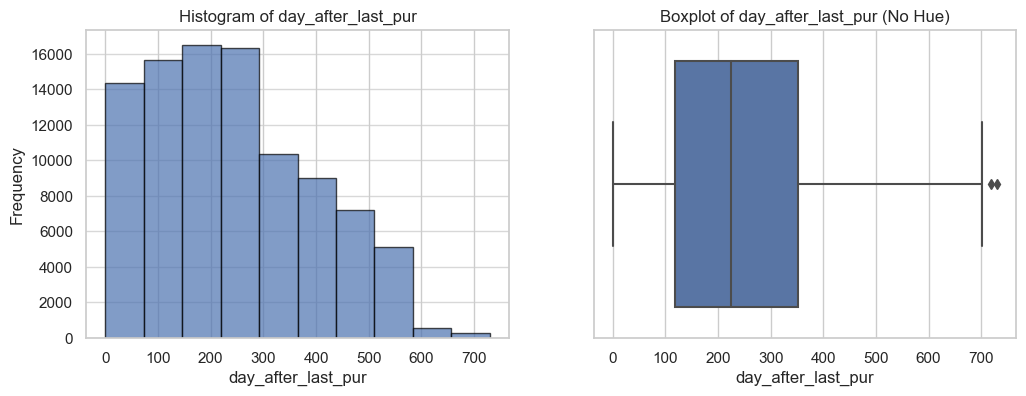

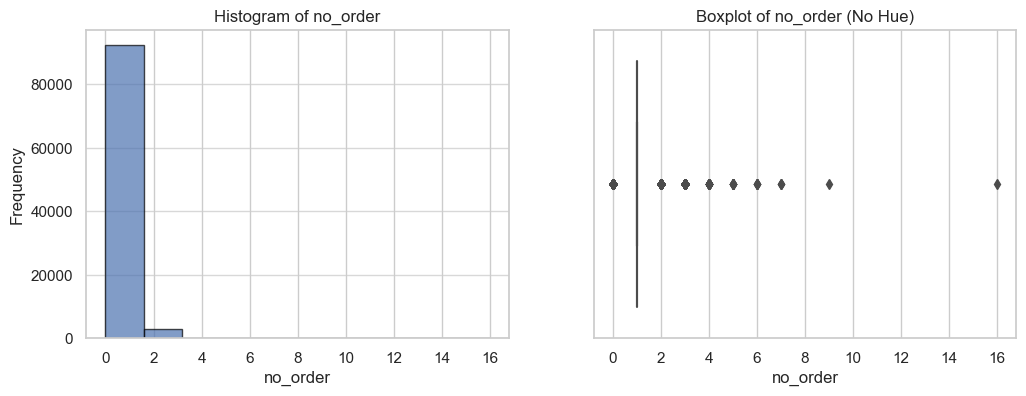

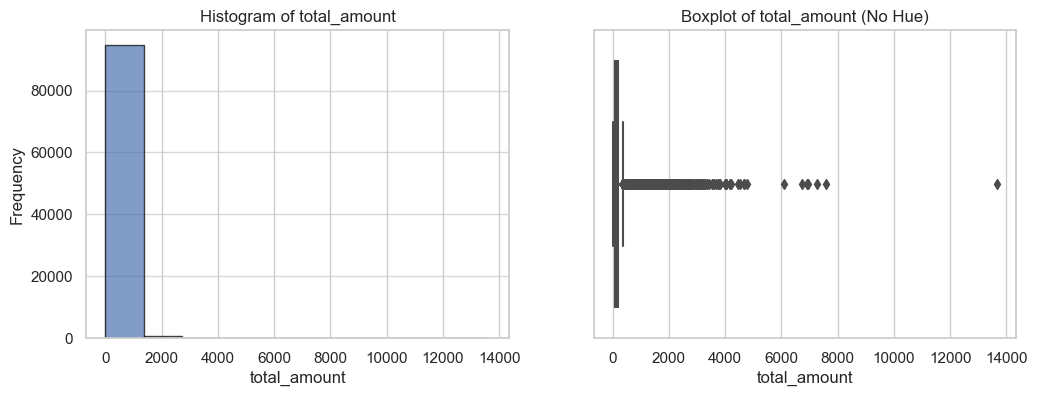

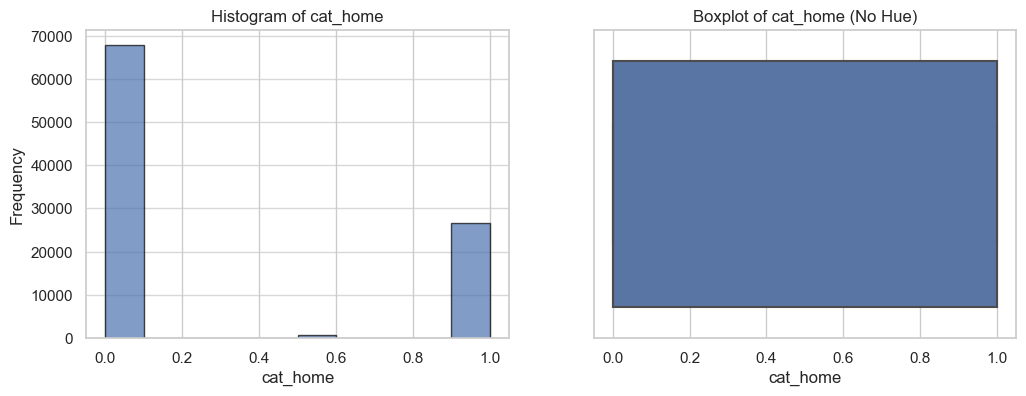

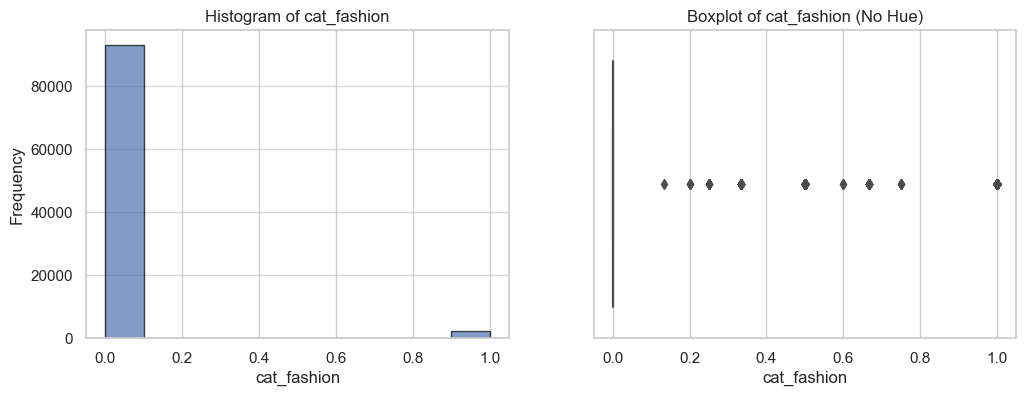

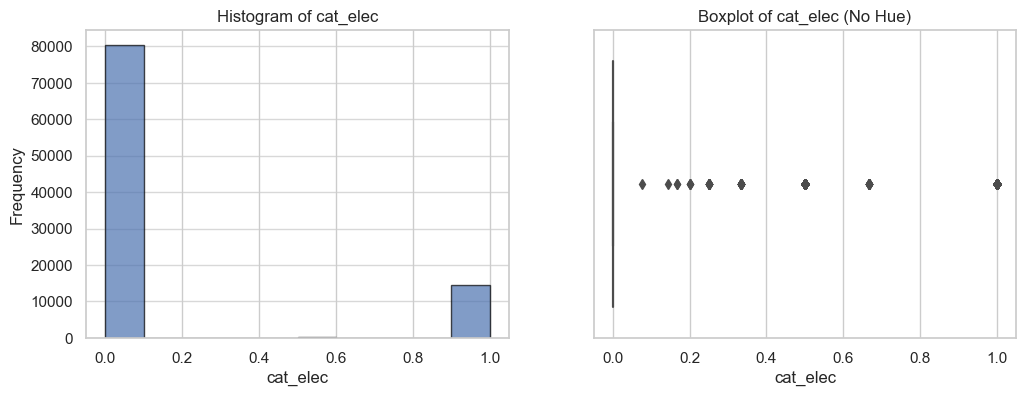

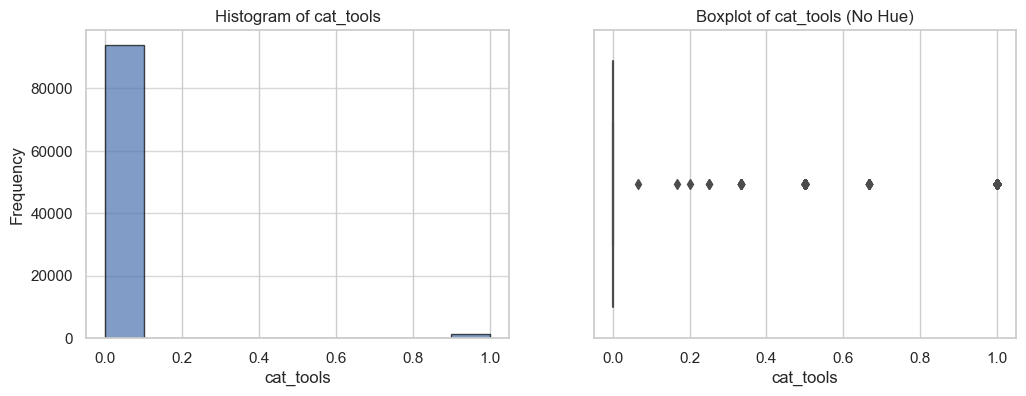

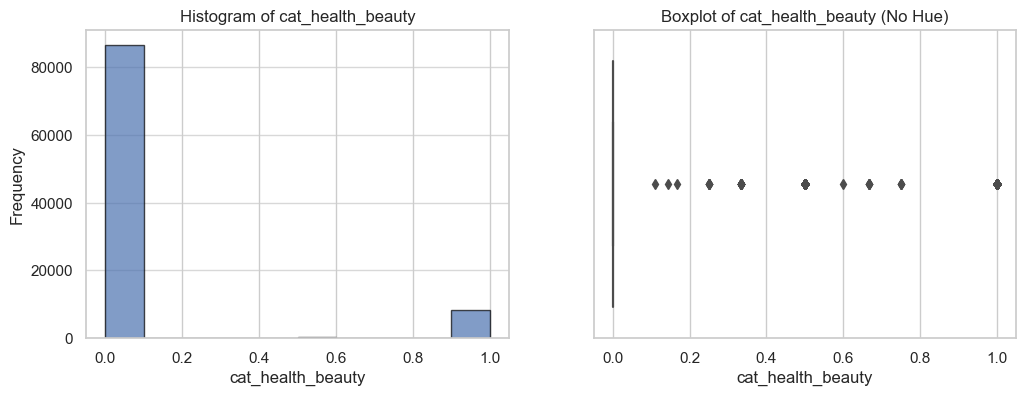

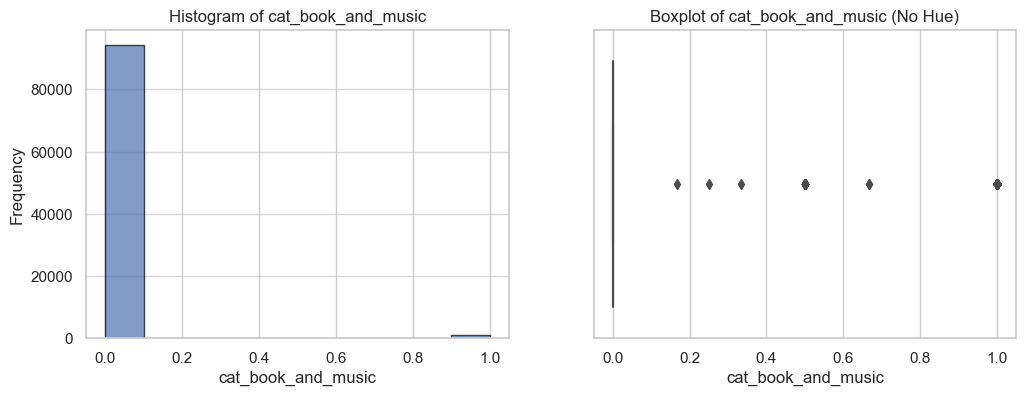

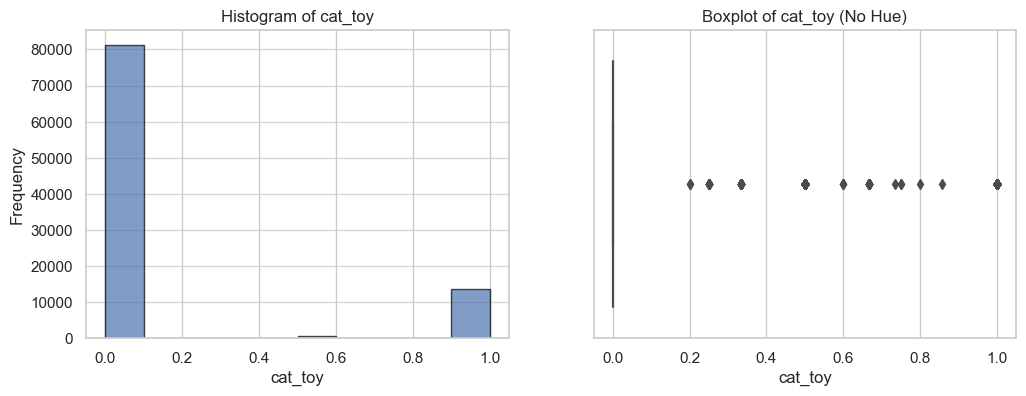

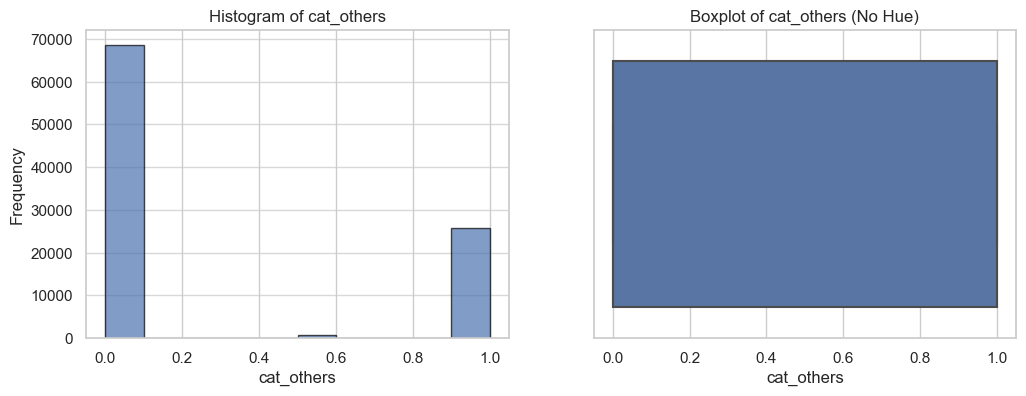

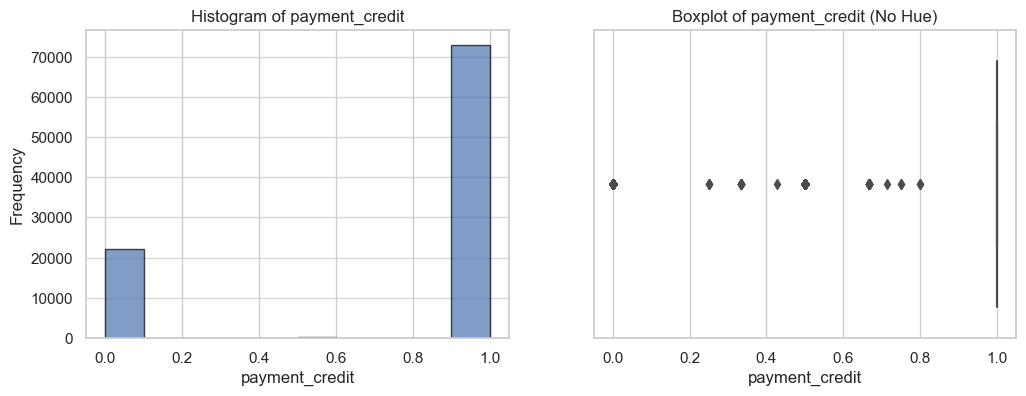

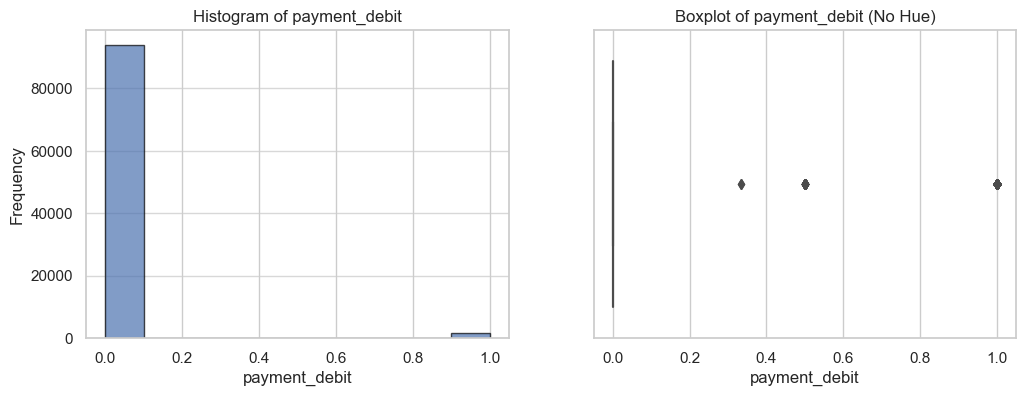

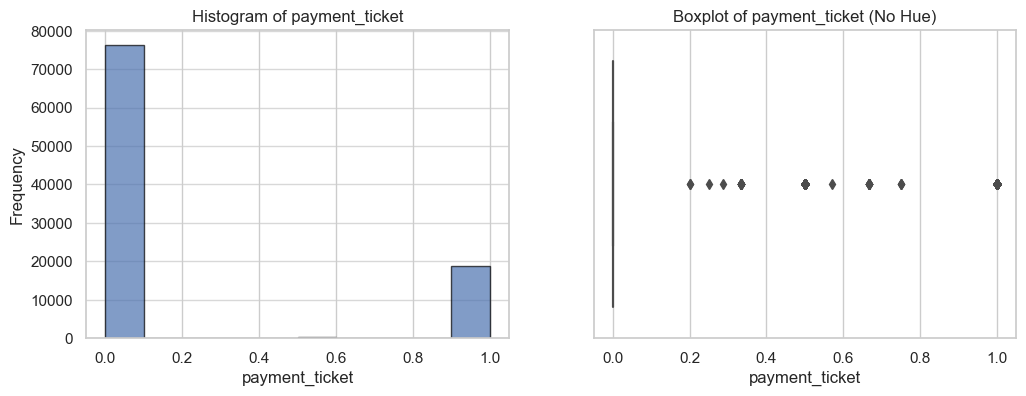

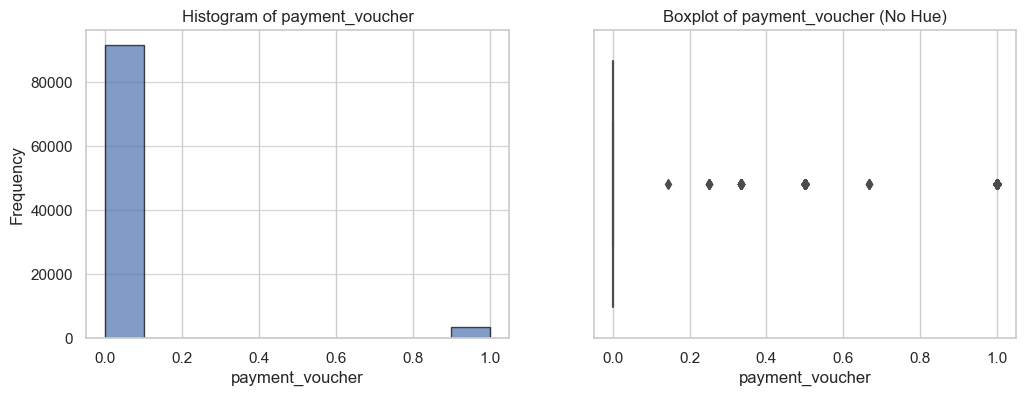

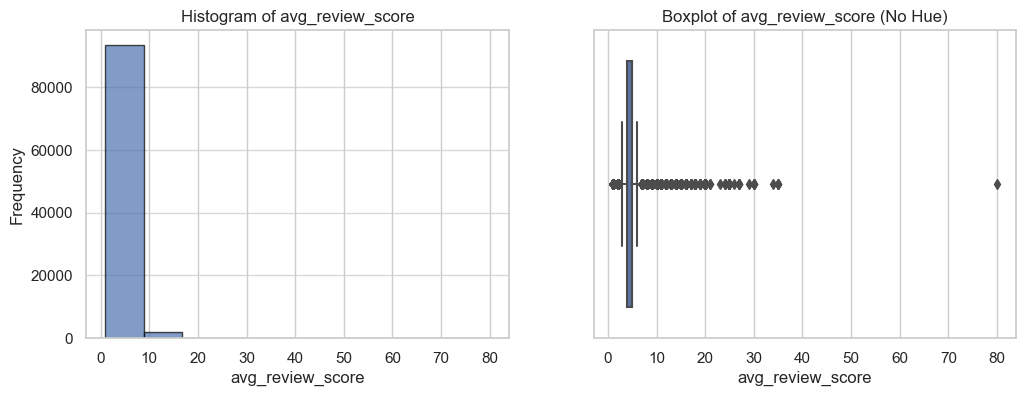

In [624]:
for column_name in num_col:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.hist(df[column_name], bins=10, edgecolor='black', alpha=0.7)
    ax1.set_title(f'Histogram of {column_name}')
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Frequency')
    ax1.grid(axis='y', alpha=0.75)
    
    if isinstance(df[column_name].dtype, pd.CategoricalDtype):
        sns.boxplot(x=df[column_name], ax=ax2)
    else:
        sns.boxplot(x=df[column_name], ax=ax2)
    ax2.set_title(f'Boxplot of {column_name} (No Hue)')
    ax2.set_xlabel(column_name)
    
    plt.show()

drop unnecessary columns

In [625]:
df.drop(columns = 'customer_unique_id', inplace = True)

correlation

In [626]:
corr = df.corr()

<Axes: >

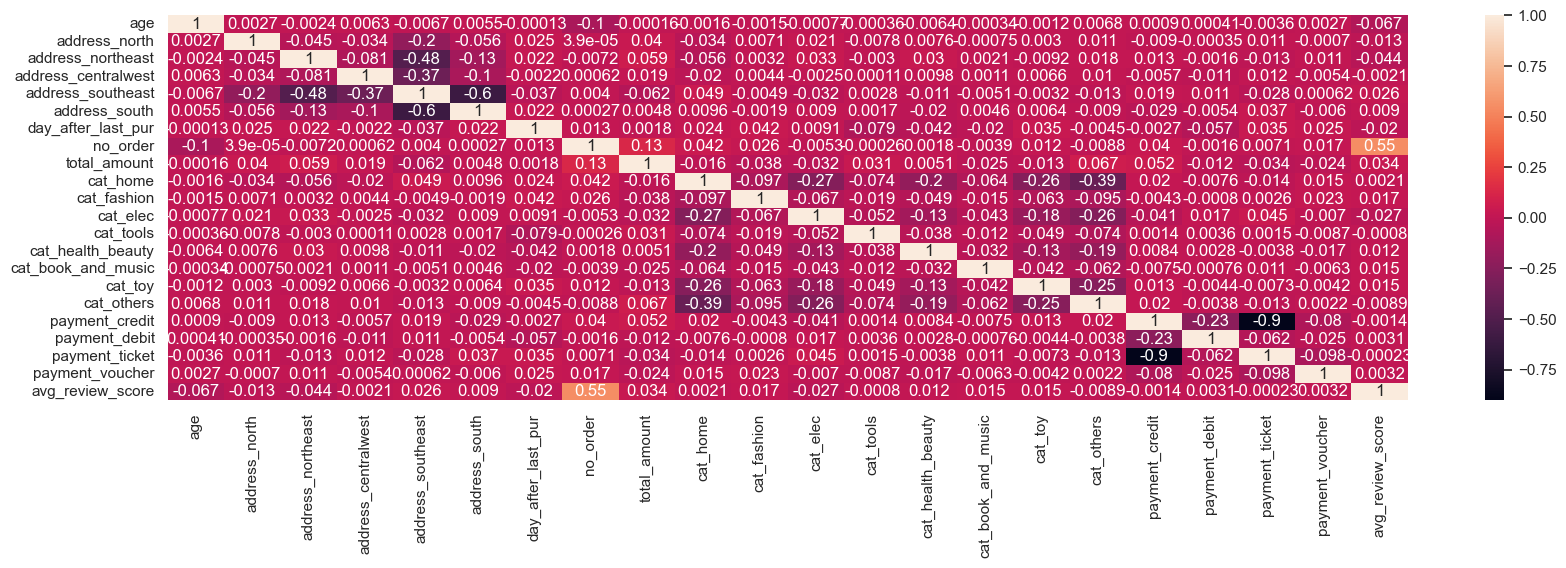

In [627]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corr, annot=True, ax=ax)

# 6. Model

In [628]:
df.head()

,age,address_north,address_northeast,address_centralwest,address_southeast,address_south,day_after_last_pur,no_order,total_amount,cat_home,...,cat_tools,cat_health_beauty,cat_book_and_music,cat_toy,cat_others,payment_credit,payment_debit,payment_ticket,payment_voucher,avg_review_score
0,63.0,0,0,0,1,0,175.0,1.0,173.30,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0
1,49.0,0,0,0,0,1,508.0,1.0,94.63,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0
2,64.0,0,0,0,1,0,357.0,1.0,73.34,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
3,71.0,0,0,0,1,0,218.0,1.0,157.12,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
4,30.0,0,0,0,1,0,196.0,1.0,18.77,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0


standardize 

In [629]:
df = df[cat_col + num_col]

In [630]:
scaler = StandardScaler()

In [631]:
scaler.fit(df)

StandardScaler()

In [632]:
df_scaled = pd.DataFrame(scaler.transform(df), columns=cat_col + num_col)

In [633]:
df

,address_north,address_northeast,address_centralwest,address_southeast,address_south,age,day_after_last_pur,no_order,total_amount,cat_home,...,cat_tools,cat_health_beauty,cat_book_and_music,cat_toy,cat_others,payment_credit,payment_debit,payment_ticket,payment_voucher,avg_review_score
0,0,0,0,1,0,63.0,175.0,1.0,173.30,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0
1,0,0,0,0,1,49.0,508.0,1.0,94.63,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0
2,0,0,0,1,0,64.0,357.0,1.0,73.34,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
3,0,0,0,1,0,71.0,218.0,1.0,157.12,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
4,0,0,0,1,0,30.0,196.0,1.0,18.77,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96091,0,0,0,1,0,27.0,14.0,1.0,47.44,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0
96092,0,0,0,1,0,37.0,541.0,1.0,83.06,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
96093,0,0,0,1,0,44.0,336.0,1.0,36.69,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0
96094,0,0,0,0,1,63.0,93.0,1.0,128.31,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0


In [634]:
df_scaled

,address_north,address_northeast,address_centralwest,address_southeast,address_south,age,day_after_last_pur,no_order,total_amount,cat_home,...,cat_tools,cat_health_beauty,cat_book_and_music,cat_toy,cat_others,payment_credit,payment_debit,payment_ticket,payment_voucher,avg_review_score
0,-0.137912,-0.324273,-0.248697,0.677347,-0.407559,0.997800,-0.444335,-0.131455,0.036920,-0.632317,...,-0.122221,-0.314619,-0.101361,-0.413520,1.633347,0.553187,-0.12586,-0.498403,-0.198348,0.416475
1,-0.137912,-0.324273,-0.248697,-1.476349,2.453631,0.161324,1.724735,-0.131455,-0.310404,-0.632317,...,-0.122221,-0.314619,-0.101361,2.446313,-0.619498,0.553187,-0.12586,-0.498403,-0.198348,0.416475
2,-0.137912,-0.324273,-0.248697,0.677347,-0.407559,1.057549,0.741163,-0.131455,-0.404398,1.599329,...,-0.122221,-0.314619,-0.101361,-0.413520,-0.619498,-1.814954,-0.12586,2.014648,-0.198348,-0.160637
3,-0.137912,-0.324273,-0.248697,0.677347,-0.407559,1.475787,-0.164245,-0.131455,-0.034514,-0.632317,...,-0.122221,-0.314619,-0.101361,2.446313,-0.619498,0.553187,-0.12586,-0.498403,-0.198348,-0.737750
4,-0.137912,-0.324273,-0.248697,0.677347,-0.407559,-0.973895,-0.307547,-0.131455,-0.645322,-0.632317,...,-0.122221,-0.314619,-0.101361,2.446313,-0.619498,0.553187,-0.12586,-0.498403,-0.198348,0.416475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95415,-0.137912,-0.324273,-0.248697,0.677347,-0.407559,-1.153140,-1.493044,-0.131455,-0.518746,-0.632317,...,-0.122221,-0.314619,-0.101361,-0.413520,-0.619498,0.553187,-0.12586,-0.498403,-0.198348,-0.160637
95416,-0.137912,-0.324273,-0.248697,0.677347,-0.407559,-0.555656,1.939688,-0.131455,-0.361485,-0.632317,...,-0.122221,-0.314619,-0.101361,2.446313,-0.619498,0.553187,-0.12586,-0.498403,5.097012,-1.891975
95417,-0.137912,-0.324273,-0.248697,0.677347,-0.407559,-0.137418,0.604374,-0.131455,-0.566206,-0.632317,...,-0.122221,-0.314619,-0.101361,-0.413520,-0.619498,0.553187,-0.12586,-0.498403,-0.198348,0.416475
95418,-0.137912,-0.324273,-0.248697,-1.476349,2.453631,0.997800,-0.978460,-0.131455,-0.161708,1.599329,...,-0.122221,-0.314619,-0.101361,-0.413520,-0.619498,0.553187,-0.12586,-0.498403,-0.198348,0.416475


PCA

In [635]:
pca = PCA(n_components=2)

In [636]:
df_pca = pd.DataFrame(data=pca.fit_transform(df_scaled), columns=['Principal Component 1', 'Principal Component 2'])

In [637]:
df_pca

,Principal Component 1,Principal Component 2
0,1.018689,-0.445867
1,0.007631,2.169663
2,-2.242096,-1.830820
3,0.911994,-0.506010
4,0.966775,-0.724887
...,...,...
95415,0.677358,-0.672317
95416,0.879274,-0.439970
95417,0.618987,-0.573559
95418,0.205715,1.721247


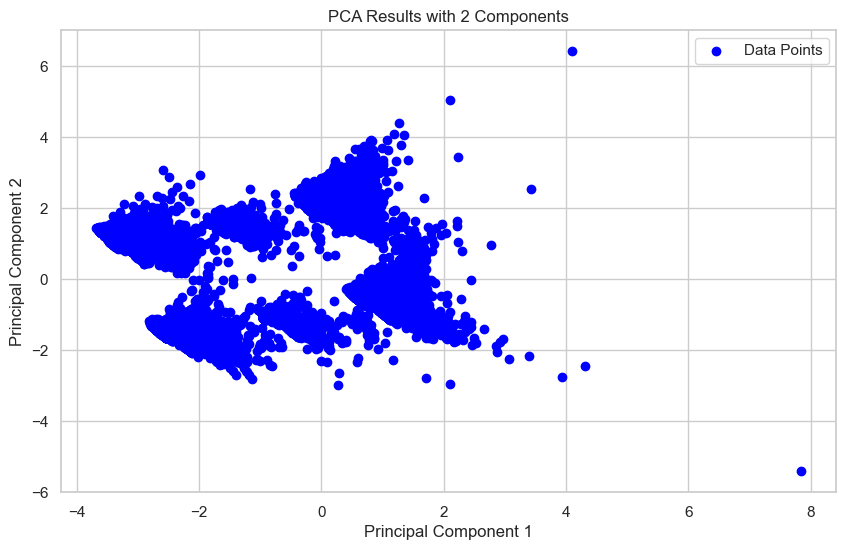

In [638]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'], c='blue', label='Data Points')

plt.title('PCA Results with 2 Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.show()

KMeans (df_scaled) where k = 3

In [639]:
k = 3

In [640]:
kmeans_scaled = KMeans(n_clusters=k, random_state=42)

In [641]:
kmeans_scaled.fit(df_scaled)

KMeans(n_clusters=3, random_state=42)

In [642]:
clusters_scaled = kmeans_scaled.predict(df_scaled)

In [643]:
clusters_scaled

array([1, 2, 0, ..., 1, 2, 2])

KMeans (df_pca) where k = 3

In [644]:
k = 3

In [645]:
kmeans_scaled_pca = KMeans(n_clusters=k, random_state=42)

In [646]:
kmeans_scaled.fit(df_pca)

KMeans(n_clusters=3, random_state=42)

In [647]:
clusters_pca = kmeans_scaled.predict(df_pca)

In [648]:
clusters_pca

array([0, 2, 1, ..., 0, 2, 2])

Plot

In [649]:
df_pca['cluster (scaled)'] = clusters_scaled
df_pca['cluster (pca)'] = clusters_pca

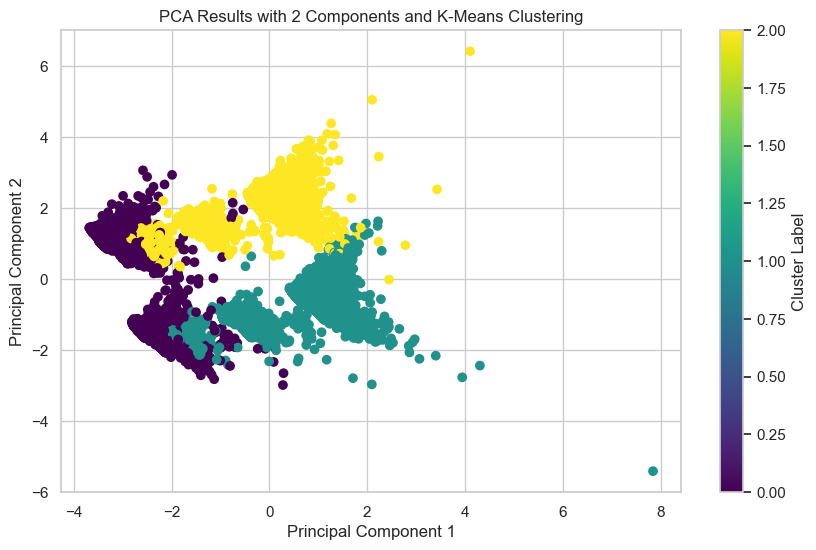

In [650]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'], c=df_pca['cluster (scaled)'], cmap='viridis', label='Cluster Label')
plt.colorbar(label='Cluster Label')

plt.title('PCA Results with 2 Components and K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

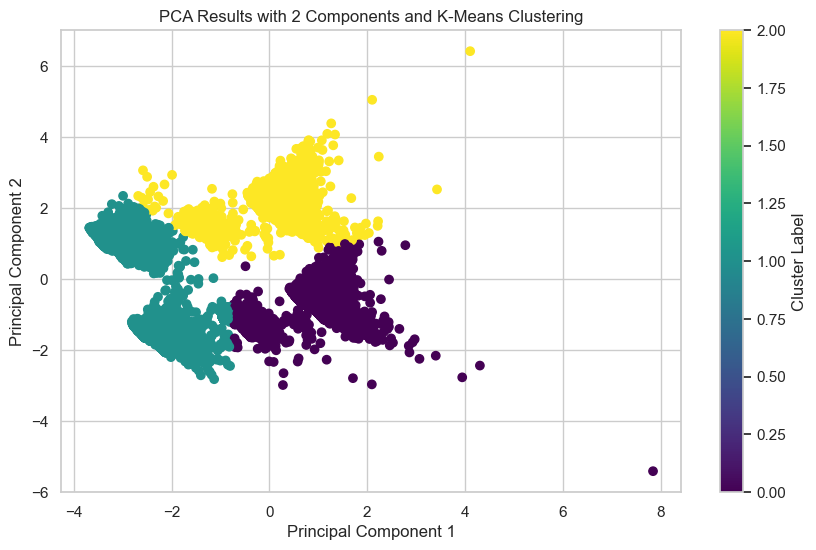

In [651]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'], c=df_pca['cluster (pca)'], cmap='viridis', label='Cluster Label')
plt.colorbar(label='Cluster Label')

plt.title('PCA Results with 2 Components and K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()